<a href="https://colab.research.google.com/github/RaulVictor11/neural_networks/blob/main/neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#📌 **Visão Geral do Projeto**

Este projeto desenvolve um modelo de Machine Learning capaz de classificar alimentos como saudáveis (1) ou não saudáveis (0) com base em suas características nutricionais, utilizando uma Rede Neural Multilayer Perceptron (MLP).

A base utilizada contém informações detalhadas de mais de 14.000 alimentos, incluindo macro e micronutrientes fornecidos pelo USDA (United States Department of Agriculture).
O objetivo é demonstrar um pipeline completo de Aprendizado de Máquina:

- Coleta de dados

- Limpeza e tratamento profundo

- Criação da variável alvo

- Engenharia de atributos

- Aplicação de técnicas de normalização

- Construção, treinamento e avaliação de um modelo MLP

Link da base utilizada:
https://www.kaggle.com/datasets/waltonj/usda-myfooddata-nutrition-facts-2020/data?select=MyFoodData_USDA_05142025.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("https://raw.githubusercontent.com/RaulVictor11/neural_networks/refs/heads/main/MyFoodData_USDA_05142025.csv")

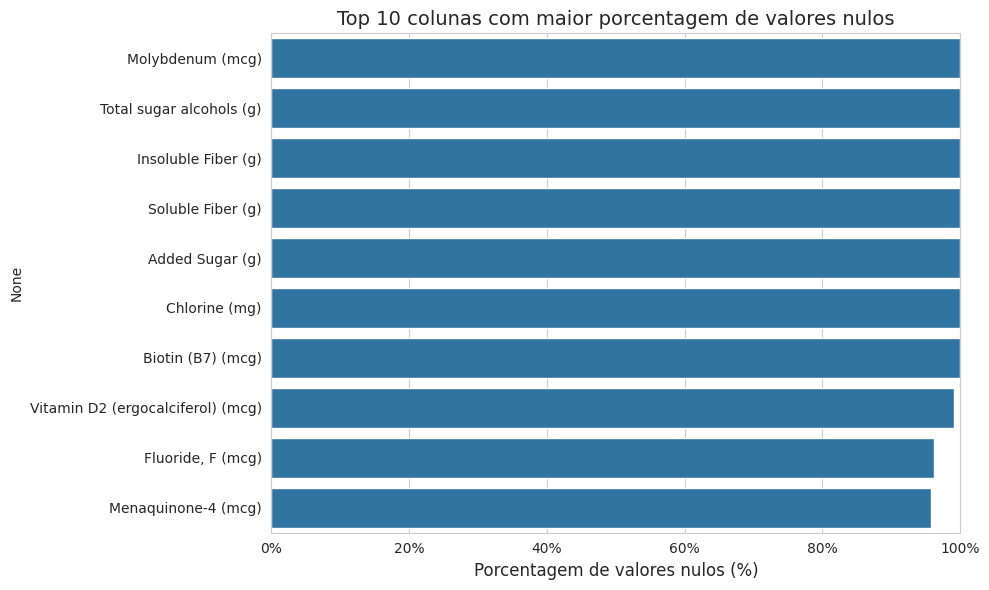

In [2]:
null_pct = df.isna().mean() * 100

# Ordenando e trazendo top 10 colunas com maior porcentagem de nulos
top10 = null_pct.sort_values(ascending=False).head(10)

# Plotando barra horizontal: Mais legível para nomes longos
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")

# Barplot horizontal
sns.barplot(x=top10.values, y=top10.index)

# Rótulos
plt.xlabel('Porcentagem de valores nulos (%)', fontsize=12)
plt.title('Top 10 colunas com maior porcentagem de valores nulos', fontsize=14)
plt.xlim(0, 100)
plt.gca().xaxis.set_major_formatter(lambda x, pos: f'{x:.0f}%')
plt.tight_layout()
plt.show()


As seguintes colunas foram excluídas por terem altíssimo índice de nulabilidade, baixa relevância para o modelo ou por representarem um micronutriente raro que poucos alimentos contêm.

In [3]:
#Colunas a serem excluídas
lista_remocao = ['ID', 'Serving Weight 1 (g)',
'Serving Description 1 (g)',
'Serving Weight 2 (g)',
'Serving Description 2 (g)',
'Serving Weight 3 (g)',
'Serving Description 3 (g)',
'Serving Weight 4 (g)',
'Serving Description 4 (g)',
'Serving Weight 5 (g)',
'Serving Description 5 (g)',
'Serving Weight 6 (g)',
'Serving Description 6 (g)',
'Serving Weight 7 (g)',
'Serving Description 7 (g)',
'Serving Weight 8 (g)',
'Serving Description 8 (g)',
'Serving Weight 9 (g)',
'Serving Description 9 (g)',
'Vitamin A, IU (IU)',
'Added Sugar (g)',
'Trans Fatty Acids (g)',
'Soluble Fiber (g)',
'Insoluble Fiber (g)',
'Sucrose (g)',
'Glucose (Dextrose) (g)',
'Fructose (g)',
'Lactose (g)',
'Maltose (g)',
'Galactose (g)',
'Starch (g)',
'Total sugar alcohols (g)',
'Manganese (mg)',
'Fluoride, F (mcg)',
'Molybdenum (mcg)',
'Chlorine (mg)',
'Pantothenic acid (B5) (mg)',
'Biotin (B7) (mcg)',
'Betaine (mg)',
'Vitamin D2 (ergocalciferol) (mcg)',
'Vitamin D3 (cholecalciferol) (mcg)',
'Vitamin D (IU) (IU)',
'Dihydrophylloquinone (mcg)',
'Menaquinone-4 (mcg)',
'18:3 n-3 c,c,c (ALA) (mg)',
'200 Calorie Weight (g)',]

In [4]:
#Removendo colunas ruidosas e/ou nulabilidade alta e baixa relevância
df.drop(lista_remocao, axis=1, inplace=True)


Para não prejudicar o aprendizado do modelo, optou-se por excluir as linhas com valor nulo de nutrientes críticos a tentar inferir erroneamente.

In [5]:
#Excluindo linhas que possuírem NaN em alguma dessas colunas

df.dropna(subset=['Food Group','Fatty acids, total monounsaturated (mg)', 'Fatty acids, total polyunsaturated (mg)', 'Sodium (mg)', 'Sugars (g)', 'Vitamin E (Alpha-Tocopherol) (mg)', 'Vitamin C (mg)', 'Folate (B9) (mcg)',
            'Folate DFE (mcg)', 'Folic acid (mcg)', 'Vitamin B6 (mg)', 'Thiamin (B1) (mg)', 'Riboflavin (B2) (mg)', 'Vitamin A, RAE (mcg)',
            'Niacin (B3) (mg)', 'Zinc, Zn (mg)', 'Iron, Fe (mg)', 'Magnesium (mg)', 'Potassium, K (mg)', 'Calcium (mg)', 'Selenium, Se (mcg)',
            'Phosphorus, P (mg)', 'Copper, Cu (mg)'], inplace=True)

# Regra Vitamina B12
mask_vegetal = df['Food Group'].isin(['Fruits', 'Vegetables', 'Beans and Lentils',
                                      'Grains and Pasta', 'Nuts and Seeds'])
df.loc[mask_vegetal, 'Vitamin B-12 (mcg)'] = df.loc[mask_vegetal, 'Vitamin B-12 (mcg)'].fillna(0)

# Removendo de alimentos de origem animal
df = df[~(df['Vitamin B-12 (mcg)'].isna() & ~mask_vegetal)]


#Corrigindo coluna Retinol:
veg_groups = [
    'Fruits', 'Vegetables', 'Beans and Lentils',
    'Grains and Pasta', 'Nuts and Seeds'
]

mask_vegetal = df['Food Group'].isin(veg_groups)

df.loc[mask_vegetal, 'Retinol (mcg)'] = df.loc[mask_vegetal, 'Retinol (mcg)'].fillna(0)

# Grupos de origem animal: retinol deve existir
animal_groups = ['Meats', 'Fish', 'Dairy and Egg Products']
mask_animal = df['Food Group'].isin(animal_groups)

# Removendo animais com retinol faltante
df = df[~(df['Retinol (mcg)'].isna() & mask_animal)]

# Removendo todos os outros retinol faltantes (desconhecidos)
df = df[~df['Retinol (mcg)'].isna()]



In [6]:
# Correção de nome para padronização
df.loc[df['Food Group'] == 'Dairy and Egg Products ', 'Food Group'] = 'Dairy and Egg Products'

In [7]:
# Nome mais descritivo para a coluna de calorias
df.rename(columns={'Calories': 'Calories (100g)'}, inplace=True)

In [8]:
# Criação da coluna que avalia qualidade da(s) gordura(s) presente(s) no alimento
fat = df['Fat (g)'] * 1000
unsat = df['Fatty acids, total monounsaturated (mg)'] + df['Fatty acids, total polyunsaturated (mg)']

df['unsat_ratio'] = unsat / fat

# Se Fat = 0, então ratio = 0 (nenhuma gordura insaturada)
df.loc[df['Fat (g)'] == 0, 'unsat_ratio'] = 0

# Removendo quaisquer inf/NaN remanescentes
df['unsat_ratio'].replace([np.inf, -np.inf], 0, inplace=True)
df['unsat_ratio'].fillna(0, inplace=True)



/tmp/ipython-input-3687636770.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['unsat_ratio'].replace([np.inf, -np.inf], 0, inplace=True)
/tmp/ipython-input-3687636770.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace

Nas seguintes colunas a inputação com zero (0) foi a abordagem escolhida, pois o valor nulo indica uma provável ausência ou quantidade indetectável do aminoácido no alimento.






In [9]:
# Preenchendo nulos com 0

colunas = [
    'Tryptophan (mg)', 'Threonine (mg)', 'Isoleucine (mg)', 'Leucine (mg)',
    'Lysine (mg)', 'Methionine (mg)', 'Cystine (mg)', 'Phenylalanine (mg)',
    'Tyrosine (mg)', 'Valine (mg)', 'Arginine (mg)', 'Histidine (mg)',
    'Alanine (mg)', 'Aspartic acid (mg)', 'Glutamic acid (mg)', 'Fiber (g)',
    'Glycine (mg)', 'Proline (mg)', 'Serine (mg)', 'Hydroxyproline (mg)',
  'Choline (mg)', 'Vitamin K (mcg)', 'Caffeine (mg)', 'Theobromine (mg)', '22:5 n-3 (DPA) (mg)',
  'Carotene, beta (mcg)', 'Carotene, alpha (mcg)', 'Lutein + Zeaxanthin (mcg)', 'Lycopene (mcg)', '20:5 n-3 (EPA) (mg)',
  '22:6 n-3 (DHA) (mg)', 'Alcohol (g)', 'Vitamin D (mcg)', 'Omega 3s (mg)',
  'Omega 6s (mg)', 'Saturated Fats (g)','unsat_ratio'
]

len(colunas)
df.loc[:, colunas] = df.loc[:, colunas].fillna(0)

In [10]:
# Tratamento especial na coluna de Colesterol

# Grupos obrigatoriamente zero-colesterol (vegetais)
grupo_vegetal = [
    'Vegetables', 'Fruits', 'Grains and Pasta', 'Nuts and Seeds',
    'Beans and Lentils', 'Spices and Herbs'
]

# Inputando 0 ao grupo vegetais
mask_veg = df['Food Group'].isin(grupo_vegetal)
df.loc[mask_veg, 'Cholesterol (mg)'] = df.loc[mask_veg, 'Cholesterol (mg)'].fillna(0)

# Inputando mediana dentro do próprio grupo para alimentos de origem animal
mask_animal = ~mask_veg

for group, subset in df[mask_animal].groupby('Food Group'):
    mediana = subset['Cholesterol (mg)'].median()
    mask_nulls = (df['Food Group'] == group) & (df['Cholesterol (mg)'].isna())
    df.loc[mask_nulls, 'Cholesterol (mg)'] = mediana


In [11]:
# Contagem nulabilidade no DataFrame
total_nulos = df.isnull().sum().sum()

print(f"O número total de valores nulos no DataFrame é: {total_nulos}")

O número total de valores nulos no DataFrame é: 0


Foram criadas máscaras para facilitar a classificação dos alimentos.

In [12]:
# ============================================
# CLASSIFICAÇÃO DE ALIMENTOS
# ============================================

#Criação de máscaras para cada grupo de alimentos
is_fruit = df['Food Group'].eq('Fruits')
is_vegetables = df['Food Group'].eq('Vegetables')
is_oil = df['Food Group'].eq('Fats and Oils')
is_meat = df['Food Group'].eq('Meats')
is_seafood = df['Food Group'].eq('Fish')

is_egg = df[(df['name'].str.contains('egg', case=False, na=False)) & (df['Food Group'] == 'Dairy and Egg Products')]

is_nuts_and_seeds = df['Food Group'].eq('Nuts and Seeds')

is_processed = df['Food Group'].isin([
    'Baked Foods', 'Snacks', 'Sweets', 'Breakfast Cereals',
    'Prepared Meals', 'Fast Foods', 'Restaurant Foods',
    'Soups and Sauces', 'Beverages'
])

is_processed_meat = df['name'].str.contains(
    'sausage|ham|bacon|salami|deli|smoked|pepperoni',
    case=False, na=False
)

A lógica utilizada no sistema de pontuação do presente projeto foi inspirada no sistema de rotulagem nutricional europeu Nutri-Score, que é um sistema de rotulagem nutricional desenvolvido para facilitar a compreensão das informações nutricionais pelos consumidores e, assim, ajudá-los a fazer escolhas conscientes. Nele, os rótulos também são atribuídos de acordo com a pontuação do alimento.


https://www.santepubliquefrance.fr/en/nutri-score



In [13]:
# ============================================
# SISTEMA DE PONTUAÇÃO PARA INFERÊNCIA DO TARGET
# ============================================

df['Final_Score'] = 0


# --------------------------------------------
# Penalizando gordura saturada (exceto óleos)
# --------------------------------------------
mask = ~is_oil

df.loc[mask & (df['Saturated Fats (g)'] > 10), 'Final_Score'] -= 3
df.loc[mask & (df['Saturated Fats (g)'] >= 5) &
              (df['Saturated Fats (g)'] <= 10), 'Final_Score'] -= 1


# --------------------------------------------
# Penalizando açúcares refinados
# --------------------------------------------
mask_refinado = (df['Sugars (g)'] >= 15) & (df['Fiber (g)'] < 1)
df.loc[mask_refinado, 'Final_Score'] -= 2

mask_fruta = (df['Sugars (g)'] >= 15) & (df['Fiber (g)'] >= 2)
# frutas não são penalizadas; logo, não há .loc aqui


# --------------------------------------------
# Penalizando sódio em alimentos processados
# --------------------------------------------
df.loc[is_processed & (df['Sodium (mg)'] >= 800), 'Final_Score'] -= 2
df.loc[is_processed & (df['Sodium (mg)'] >= 400) &
                      (df['Sodium (mg)'] < 800), 'Final_Score'] -= 1


# --------------------------------------------
# Penalizando colesterol (exceto ovos e frutos do mar)
# --------------------------------------------
is_egg_mask = df['name'].str.contains('egg', case=False, na=False) & (df['Food Group'] == 'Dairy and Egg Products')

mask = ~(is_egg_mask | is_seafood)

df.loc[mask & (df['Cholesterol (mg)'] >= 100), 'Final_Score'] -= 1


# --------------------------------------------
# Avaliação de gorduras (unsat_ratio)
# --------------------------------------------
mask = (is_oil | is_meat | is_processed | is_nuts_and_seeds)

df.loc[mask & (df['unsat_ratio'] >= 0.7), 'Final_Score'] += 1
df.loc[mask & (df['unsat_ratio'] <= 0.4), 'Final_Score'] -= 1


# --------------------------------------------
# Pontos positivos: FIBRAS
# --------------------------------------------
df.loc[df['Fiber (g)'] >= 6, 'Final_Score'] += 2
df.loc[(df['Fiber (g)'] >= 3) & (df['Fiber (g)'] < 6), 'Final_Score'] += 1


# --------------------------------------------
# Pontos positivos: PROTEÍNAS
# --------------------------------------------
df.loc[df['Protein (g)'] >= 15, 'Final_Score'] += 2
df.loc[(df['Protein (g)'] >= 7) & (df['Protein (g)'] < 15), 'Final_Score'] += 1


# --------------------------------------------
# Pontos positivos: VITAMINAS E MINERAIS
# --------------------------------------------
df.loc[df['Iron, Fe (mg)'] >= 2.5, 'Final_Score'] += 1
df.loc[df['Potassium, K (mg)'] >= 450, 'Final_Score'] += 1
df.loc[df['Vitamin C (mg)'] >= 10, 'Final_Score'] += 1

In [14]:
#Criação e atribuição da coluna target
df['is_healthy'] = np.where(df['Final_Score'] >= 2, 1,
                     np.where(df['Final_Score'] <= 1, 0, np.nan))

#Solucionando casos de empate
for group, subset in df.groupby('Food Group'):
    mask = (df['Food Group'] == group) & (df['is_healthy'].isna())
    if mask.sum() > 0:
        # classe dominante do grupo
        dominante = subset['is_healthy'].dropna().mode()
        if len(dominante) > 0:
            df.loc[mask, 'is_healthy'] = dominante.iloc[0]
        else:
            df.loc[mask, 'is_healthy'] = 0


In [15]:
#Verificando proporção de alimentos saudáveis e não-saudáveis
resumo = pd.DataFrame({
    'Contagem': df['is_healthy'].value_counts(),
    'Percentual': df['is_healthy'].value_counts(normalize=True).map('{:.1%}'.format)
})

print(resumo)

            Contagem Percentual
is_healthy                     
0.0             7402      67.8%
1.0             3516      32.2%


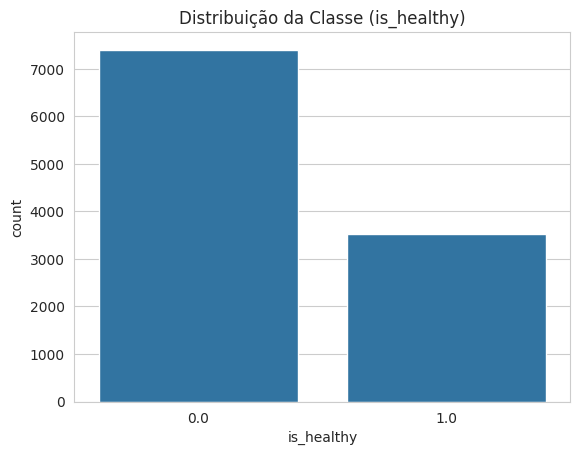

In [16]:
#Visão gráfica da distribuição entre alimentos saudáveis e não saudáveis
import seaborn as sns
sns.countplot(x=df['is_healthy'])
plt.title('Distribuição da Classe (is_healthy)')
plt.show()


In [17]:
#Excluindo coluna "nome" para iniciar o treinamento
df = df.drop(columns=['name'])

#Aplicando One-hot Encoding a coluna Food Group
df = pd.get_dummies(df, columns=["Food Group"], dtype=float)


In [18]:
#Formando conjuntos de treinamento e teste:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['is_healthy']).values.astype(np.float32)
y = df['is_healthy'].values.astype(np.float32)

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=42)

print('Conjunto de treinamento e teste separado!')

Conjunto de treinamento e teste separado!


Ajustando a topologia...
Entradas = 92
Saídas = 1
Digite a quantidade de camadas ocultas: 1
Neurônios na 1ª camada oculta: 10


Treinamento...
Digite a quantidade de épocas: 10
MLPClassifier(alpha=0.1, hidden_layer_sizes=(10,), learning_rate='adaptive',
              learning_rate_init=0.01, max_iter=10, random_state=121,
              solver='sgd', verbose=0)
Topologia da MLP = [92, 10, 1]


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


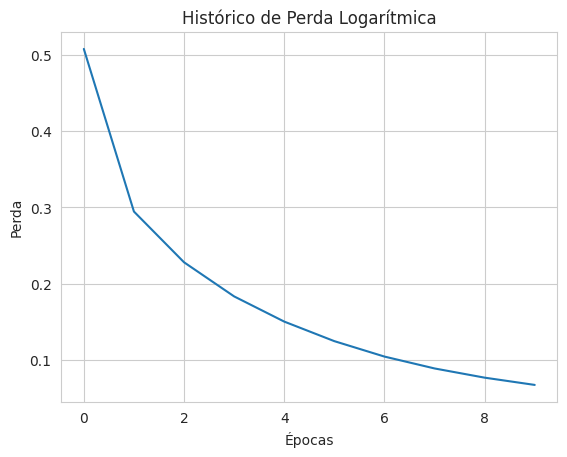

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

print('Ajustando a topologia...')
num_x = train_x.shape[1]
num_y = 1

print(f'Entradas = {num_x}\nSaídas = {num_y}')

# ========================
# Arquitetura da MLP
# ========================
while True:
    num_hidden_layers = int(input('Digite a quantidade de camadas ocultas: '))
    if num_hidden_layers > 0:
        break

topology = []
for i in range(num_hidden_layers):
    while True:
        n = int(input(f'Neurônios na {i+1}ª camada oculta: '))
        if n > 0:
            topology.append(n)
            break

# ========================
# Treinamento
# ========================
print('\n\nTreinamento...')
epochs = int(input('Digite a quantidade de épocas: '))

# Scaler
scaler = StandardScaler()
p_train_x = scaler.fit_transform(train_x)

# MLP
Model = MLPClassifier(
    hidden_layer_sizes=tuple(topology),
    activation='relu',
    max_iter=epochs,
    alpha=0.1,
    solver='sgd',
    learning_rate_init=0.01,
    momentum=0.9,
    learning_rate='adaptive',
    verbose=0,
    random_state=121
)

model = Model.fit(p_train_x, train_y.astype(int))

# Mostrar topologia completa
topology_print = [num_x] + topology + [num_y]
print(model)
print('Topologia da MLP =', topology_print)

# ========================
# Curva de perda
# ========================
plt.plot(model.loss_curve_)
plt.title('Histórico de Perda Logarítmica')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.show()


Análise do Conjunto de Treinamento

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      5551
         1.0       0.99      1.00      0.99      2637

    accuracy                           0.99      8188
   macro avg       0.99      0.99      0.99      8188
weighted avg       0.99      0.99      0.99      8188

A acurácia é  0.9947484123106985


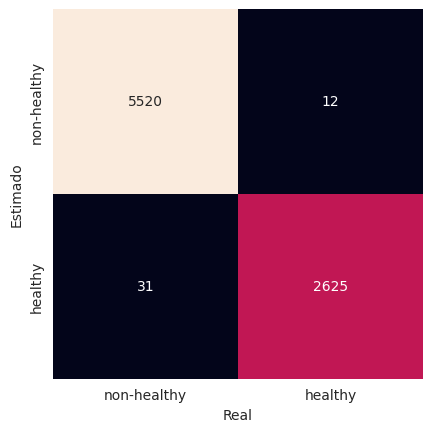

In [20]:
# Análise do conjunto de treinamento

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

train_est_y = model.predict(p_train_x)

# Definindo labels
labels = ['non-healthy', 'healthy']

# Matriz de confusão
mat = confusion_matrix(train_y, train_est_y)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Real')
plt.ylabel('Estimado');

print(classification_report(train_y, train_est_y)) # Exibe relatório
print('A acurácia é ',accuracy_score(train_est_y, train_y)) # Exibe acurácia

Análise do Conjunto de Teste

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1851
         1.0       0.99      0.99      0.99       879

    accuracy                           0.99      2730
   macro avg       0.99      0.99      0.99      2730
weighted avg       0.99      0.99      0.99      2730

A acurácia é  0.9912087912087912


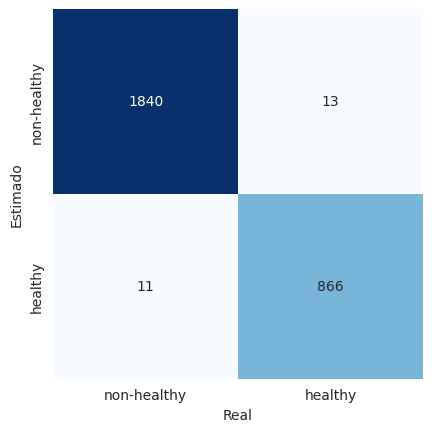

In [21]:
# Análise do conjunto de teste

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Pré-processamento
p_test_x = scaler.transform(test_x)

test_est_y = model.predict(p_test_x)

# Definindo labels
labels = ['non-healthy', 'healthy']

# Matriz de confusão
mat = confusion_matrix(test_y, test_est_y)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Real')
plt.ylabel('Estimado');

print(classification_report(test_y, test_est_y)) # Exibe relatório
print('A acurácia é ',accuracy_score(test_est_y, test_y)) # Exibe acurácia

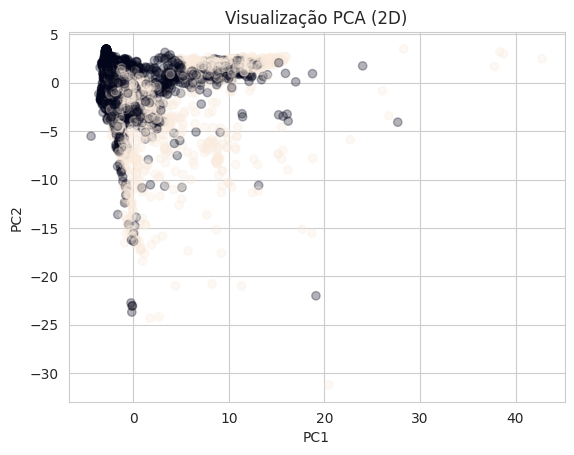

In [22]:
#Verificando linearidade dos dados com PCA

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(p_train_x)

plt.scatter(X_pca[:,0], X_pca[:,1], c=train_y, alpha=0.3)
plt.title("Visualização PCA (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
